# Exploratory Data Analysis of Weather in Illinois

In [1]:
from pathlib import Path # Library used for handling paths
import pandas as pd # DataFrame library
import numpy as np # Array library
import matplotlib.pyplot as plt # Plotting library
import os # operating system module used for storing credentials into the environment variable

### The data was extracted from the NOAA's Global Historical Climatology Network (GHCN) dataset. The SQL query was run in the Google BigQuery console as shown below. The resulting dataset was saved to a dataframe as shown in the next cell.

![Illinois Temperature Data (1990 - 2023).png](<attachment:Illinois Temperature Data (1990 - 2023).png>)

### To save on time and prevent potential costly charges, the queried result was downloaded as .csv file. It is possible to insert the queried result directly to a pandas DataFrame as shown in the code block below. Here's an example for querying just the temperature variables.

```python
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./secrets/my_credentials.json" # Credentials to be able to access the Google BigQuery public datasets
```

```python
raw_weather_query = """SELECT weather.id, weather.date, weather.element, weather.value, weather.qflag, 
                       stations.latitude, stations.longitude, stations.state, stations.name 
                       FROM `bigquery-public-data.ghcn_d.ghcnd_*` AS weather
                       INNER JOIN `bigquery-public-data.ghcn_d.ghcnd_stations` AS stations
                       ON weather.id = stations.id
                       WHERE weather.id LIKE 'US%'
                       AND weather.element IN ('TMAX', 'TMIN', 'TAVG', 'TOBS')
                       AND weather.qflag IS NULL
                       AND EXTRACT(YEAR FROM weather.date) BETWEEN 1990 AND 2023
                       AND weather._TABLE_SUFFIX BETWEEN '1990' AND '2023'
                       AND stations.id LIKE 'US%'
                       AND stations.state = 'IL'; """ # This query extracts weather data from the US in Illinois from the year 1990 to 2023
raw_weather_data = pd.read_gbq(raw_weather_query, use_bqstorage_api = True, progress_bar_type = "tqdm_notebook", dialect = "standard") # Load the data from the SQL query through Google BigQuery
```

In [73]:
desired_cols = ["date", "time", "name", "element", "value", "latitude", "longitude"]
raw_weather_data = pd.read_csv("illinois_weather_data.csv", usecols = desired_cols, dtype = {"name": "string", "time": "string", "element": "category", "value": "float", "latitude": "float", "longitude": "float"})
raw_weather_data = raw_weather_data[desired_cols]
raw_weather_data["date"] = pd.to_datetime(raw_weather_data["date"])
raw_weather_data["time"].fillna("0000", inplace = True)
raw_weather_data["time"] = raw_weather_data["time"].apply(lambda x: f"{x[:-2]}:{x[-2:]}:00")
raw_weather_data["time"] = pd.to_timedelta(raw_weather_data["time"])
raw_weather_data["date"] = raw_weather_data["date"] + raw_weather_data["time"]
raw_weather_data.drop(columns = ["time"], inplace = True)
raw_weather_data

,date,name,element,value,latitude,longitude
0,2006-05-20 08:00:00,CONGERVILLE 2NW,PRCP,0.0,40.6211,-89.2414
1,2006-05-12 06:00:00,PRAIRIE CITY 2S,PRCP,0.0,40.5914,-90.4642
2,2006-04-11 07:00:00,ST CHARLES 7 NW,PRCP,0.0,41.9603,-88.4228
3,2006-12-06 00:00:00,ROCKFORD GTR ROCKFORD AP,PRCP,3.0,42.1933,-89.0933
4,2006-10-22 07:00:00,LEBANON,PRCP,8.0,38.6003,-89.8178
...,...,...,...,...,...,...
16618313,2021-10-29 07:00:00,RAMSEY,TOBS,111.0,39.1481,-89.1022
16618314,2021-02-18 07:00:00,IUKA 12 SW,TOBS,-117.0,38.4933,-88.9708
16618315,2021-02-19 06:30:00,PAXTON 2 WSW,TOBS,-172.0,40.4550,-88.1417
16618316,2021-02-27 07:00:00,SIDELL 4N,TOBS,11.0,39.9678,-87.8228


In [75]:
raw_weather_data_pivot = raw_weather_data.pivot(columns = "element", values = "value") # Converts the categorical data in the elements column to their own respective columns
raw_weather_data_pivot

element,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,TSUN,PSUN
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
16618313,NaN,NaN,NaN,NaN,NaN,NaN,111.0,NaN,NaN
16618314,NaN,NaN,NaN,NaN,NaN,NaN,-117.0,NaN,NaN
16618315,NaN,NaN,NaN,NaN,NaN,NaN,-172.0,NaN,NaN
16618316,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN


In [78]:
transformed_data = pd.concat([raw_weather_data, raw_weather_data_pivot], axis = 1) # combine the newly generated columns with the existing dataframe
transformed_data.drop(columns = ["element", "value"], inplace = True) # drop the element and value columns
transformed_data

,date,name,latitude,longitude,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,TSUN,PSUN
0,2006-05-20 08:00:00,CONGERVILLE 2NW,40.6211,-89.2414,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-05-12 06:00:00,PRAIRIE CITY 2S,40.5914,-90.4642,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-04-11 07:00:00,ST CHARLES 7 NW,41.9603,-88.4228,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-12-06 00:00:00,ROCKFORD GTR ROCKFORD AP,42.1933,-89.0933,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-10-22 07:00:00,LEBANON,38.6003,-89.8178,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16618313,2021-10-29 07:00:00,RAMSEY,39.1481,-89.1022,NaN,NaN,NaN,NaN,NaN,NaN,111.0,NaN,NaN
16618314,2021-02-18 07:00:00,IUKA 12 SW,38.4933,-88.9708,NaN,NaN,NaN,NaN,NaN,NaN,-117.0,NaN,NaN
16618315,2021-02-19 06:30:00,PAXTON 2 WSW,40.4550,-88.1417,NaN,NaN,NaN,NaN,NaN,NaN,-172.0,NaN,NaN
16618316,2021-02-27 07:00:00,SIDELL 4N,39.9678,-87.8228,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN


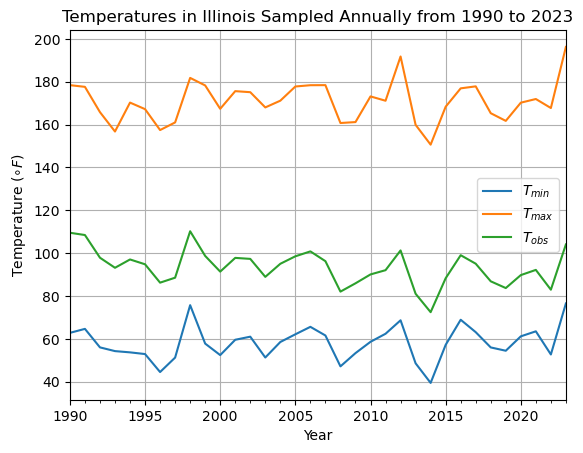

In [79]:
# This code plots the minimum, maximum, average, and observed temperatures
ax = (transformed_data[["date","TMIN", "TMAX", "TOBS"]].resample("Y", on = "date").mean() # Resample the temperature dataframe over one year (originally was sampled per day)
      .plot(xlabel = "Year", ylabel = r"Temperature ($\circ F$)", grid = True, title = "Temperatures in Illinois Sampled Annually from 1990 to 2023"))
ax.legend(loc = "best", labels = [r"$T_{min}$", r"$T_{max}$", r"$T_{obs}$"]) # Format the temperature labels

In [80]:
transformed_data["name"].nunique() # number of stations in Illinois

1912

In [82]:
transformed_data["name"].unique() # list of all the station names

<StringArray>
[         'CONGERVILLE 2NW',          'PRAIRIE CITY 2S',
          'ST CHARLES 7 NW', 'ROCKFORD GTR ROCKFORD AP',
                  'LEBANON',                 'ROBINSON',
             'EARLVILLE 3S',           'JACKSONVILLE 2',
                  'HARVARD',      'BELLEVILLE SIU RSCH',
 ...
           'COLUMBIA 0.4 S',     'DOWNERS GROVE 1.6 SE',
         'MARSHALL 1.1 SSW',           'FREEPORT 1.5 E',
            'ROYAL 1.9 ENE',             'AVON 0.3 ESE',
     'MOUNT CARMEL 0.9 NNE',           'LE ROY 0.8 SSW',
        'GALESBURG 0.7 NNE',    'CLARENDON HILLS 0.6 S']
Length: 1912, dtype: string

In [84]:
num_obs_per_station = transformed_data.groupby("name", as_index = False).count() # number of observations per station
num_obs_per_station

,name,date,latitude,longitude,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,TSUN,PSUN
0,ADDIEVILLE 5.7 SW,350,350,350,212,136,2,0,0,0,0,0,0
1,ADDISON 1.6 WNW,362,362,362,181,181,0,0,0,0,0,0,0
2,ALBERS 1 W,24134,24134,24134,9226,7479,7429,0,0,0,0,0,0
3,ALBION,31578,31578,31578,5138,5700,5388,0,5233,5072,5047,0,0
4,ALBION 0.2 SW,2746,2746,2746,1635,1105,6,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1907,YORKVILLE 2.8 NE,1322,1322,1322,885,437,0,0,0,0,0,0,0
1908,YORKVILLE 2.8 SSW,175,175,175,110,65,0,0,0,0,0,0,0
1909,YORKVILLE 2SE,11815,11815,11815,5673,3157,2985,0,0,0,0,0,0
1910,YORKVILLE 3.1 N,263,263,263,167,96,0,0,0,0,0,0,0


In [85]:
num_obs_per_station[num_obs_per_station["name"].str.contains("CHICAGO")] # number of observations per category where the station has the name "CHICAGO"

,name,date,latitude,longitude,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,TSUN,PSUN
179,BOOT CAMP-CHICAGO 4.2 SW,267,267,267,152,106,9,0,0,0,0,0,0
356,CHICAGO 2.7 WNW,750,750,750,491,259,0,0,0,0,0,0,0
357,CHICAGO 3.0 N,299,299,299,165,134,0,0,0,0,0,0,0
358,CHICAGO 3.0 NW,264,264,264,136,128,0,0,0,0,0,0,0
359,CHICAGO 3.6 NNW,573,573,573,341,232,0,0,0,0,0,0,0
360,CHICAGO 4.7 NE,6329,6329,6329,3791,2538,0,0,0,0,0,0,0
361,CHICAGO 4.8 NNW,374,374,374,254,120,0,0,0,0,0,0,0
362,CHICAGO 5.5 ESE,12038,12038,12038,5830,4337,1871,0,0,0,0,0,0
363,CHICAGO 5.5 NNW,1467,1467,1467,869,584,14,0,0,0,0,0,0
364,CHICAGO 6.0 NNE,588,588,588,280,280,28,0,0,0,0,0,0


In [86]:
num_obs_per_station.min() # Station with the least number of observations

/var/folders/j5/byfswq3j1bg3s3yk6x9qdzbr0000gp/T/ipykernel_3602/2149998279.py:1: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  num_obs_per_station.min() # Station with the least number of observations


name         ADDIEVILLE 5.7 SW
date                         1
latitude                     1
longitude                    1
PRCP                         0
SNOW                         0
SNWD                         0
TAVG                         0
TMAX                         0
TMIN                         0
TOBS                         0
TSUN                         0
PSUN                         0
dtype: object

In [87]:
num_obs_per_station.max() # Station with the most number of observations

/var/folders/j5/byfswq3j1bg3s3yk6x9qdzbr0000gp/T/ipykernel_3602/230173862.py:1: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  num_obs_per_station.max() # Station with the most number of observations


name         ZION 0.5 WNW
date                73973
latitude            73973
longitude           73973
PRCP                12376
SNOW                12376
SNWD                12376
TAVG                 7505
TMAX                12376
TMIN                12376
TOBS                12368
TSUN                 3498
PSUN                    1
dtype: object